# Predictive Modeling for Customer Churn

##Objective

Abstract: The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The objective of this assignment is to build a predictive model that can predict customer churn for a given company. The intern will use machine learning techniques to build the model and document the process, including feature selection, model evaluation, and performance metrics.


##Importing all the required libraries

In [ ]:
!pip install pandas

In [ ]:
import pandas as pd
import io
import numpy as np
import seaborn as sns
import bokeh.io
import bokeh.plotting
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_recall_curve,classification_report,roc_curve
from sklearn.metrics import confusion_matrix, plot_roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE


import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.3f' % x)
bokeh.io.output_notebook()

##Importing & loading Datasets

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving bank.csv to bank.csv
Saving test.csv to test.csv


In [ ]:
df_bank = pd.read_csv(io.BytesIO(uploaded['bank.csv']), sep=';')
df_test = pd.read_csv(io.BytesIO(uploaded['test.csv']))

##Exploring the datasets

In [ ]:
df_bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [ ]:
df_test.head()

,Id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,1,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown
1,2,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown
2,3,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown
3,4,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown
4,5,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown


###Data Dictionary 

**Input variables:**

# Bank client data:

1.   **age** (numeric)
2.   **job** : type of job
3.   **marital** : marital status
4.   **education**
5.   **default**: has credit in default?
6.   **balance**: average yearly balance, in euros
7.   **housing**: has housing loan?
8.   **loan**: has personal loan?

# related with the last contact of the current campaign:

9.   **contact**: contact communication type
10.  **day**: last contact day of the month
11.  **month**: last contact month of year
12.  **duration**: last contact duration, in seconds

# other attributes:

13.  **campaign**: number of contacts performed during this campaign and for this client
14.  **pdays**: number of days that passed by after the client was last contacted from a previous campaign
15.  **previous**: number of contacts performed before this campaign and for this client
16.  **poutcome**: outcome of the previous marketing campaign

**Output variable (desired target):**

17.  **y** - has the client subscribed a term deposit?



In [ ]:
df_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


In [ ]:
df_bank.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000,4521.000,4521.000,4521.000,4521.000,4521.000,4521.000
mean,41.170,1422.658,15.915,263.961,2.794,39.767,0.543
std,10.576,3009.638,8.248,259.857,3.110,100.121,1.694
min,19.000,-3313.000,1.000,4.000,1.000,-1.000,0.000
25%,33.000,69.000,9.000,104.000,1.000,-1.000,0.000
50%,39.000,444.000,16.000,185.000,2.000,-1.000,0.000
75%,49.000,1480.000,21.000,329.000,3.000,-1.000,0.000
max,87.000,71188.000,31.000,3025.000,50.000,871.000,25.000


In [ ]:
df_bank.duplicated().sum(), df_test.duplicated().sum()

(0, 0)

###Checking Missing Value

In [ ]:
#Creating Missing Value Function

def checkMissingData(dataset):
  total = dataset.isnull().sum().sort_values(ascending=False)
  percent = ((dataset.isnull().sum()/dataset.isnull().count())*100).sort_values(ascending=False)
  missingData = pd.concat([total, percent], axis=1, keys=['Total', 'Percent %'])
  return missingData

In [ ]:
#Checking Missing Value

missingData = checkMissingData(df_bank)
missingData

,Total,Percent %
age,0,0.000
day,0,0.000
poutcome,0,0.000
previous,0,0.000
pdays,0,0.000
campaign,0,0.000
duration,0,0.000
month,0,0.000
contact,0,0.000
job,0,0.000


✅ No Missing Data in any of the datasets Now 

In [ ]:
df_bank['y'].value_counts()

no     4000
yes     521
Name: y, dtype: int64

❌ The Data is highly Imbalanced

###Categorical Variable Vise Churn



In [ ]:
#Function for plotting category vise churn

def categoryViseChurn(x, dataset, hue, figsize = (17,5)):
  fig,axes = plt.subplots(1,1 ,figsize=figsize)
  sns.countplot(x=x, data=dataset,hue=str(hue))


#Creating function to see the highest conversion as per category

def conversionByCat(dataset, column_name):

  count = dataset[column_name].value_counts()
  yes_count = []
  no_count = []

  for i in count.keys():
    yes_count.append(len(dataset.query(f'y == "yes" & {column_name} == "{i}"')[column_name]))
    no_count.append(len(dataset.query(f'y == "no" & {column_name} == "{i}"')[column_name]))

  mat = {
      'Job' : count.keys(),
      'Total' : count.values,
      'Yes' : yes_count,
      'No' : no_count,
      'Conversion' : (yes_count/count.values)*100
  }

  mat = pd.DataFrame(mat).sort_values(['Conversion'], ascending=[False])
  return mat

####Subscription by Job

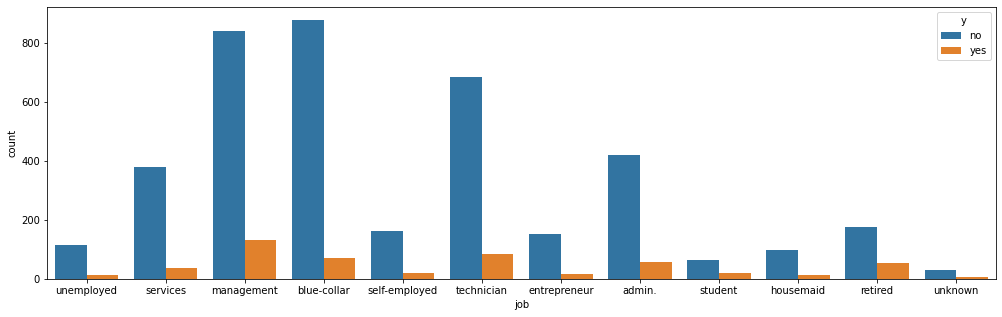

In [ ]:
categoryViseChurn("job", df_bank, "y")

In [ ]:
conversionByCat(df_bank, "job")


,Job,Total,Yes,No,Conversion
5,retired,230,54,176,23.478
10,student,84,19,65,22.619
11,unknown,38,7,31,18.421
0,management,969,131,838,13.519
9,housemaid,112,14,98,12.500
3,admin.,478,58,420,12.134
6,self-employed,183,20,163,10.929
2,technician,768,83,685,10.807
8,unemployed,128,13,115,10.156
4,services,417,38,379,9.113


####Subscription by Marital status

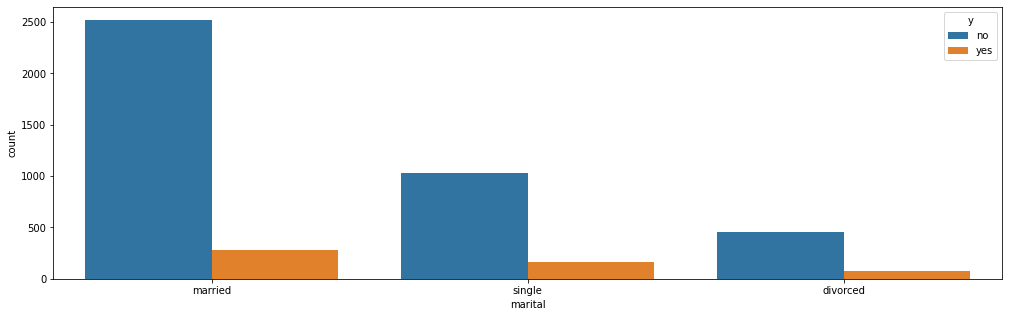

In [ ]:
categoryViseChurn("marital", df_bank, "y")

In [ ]:
conversionByCat(df_bank, "marital")

,Job,Total,Yes,No,Conversion
2,divorced,528,77,451,14.583
1,single,1196,167,1029,13.963
0,married,2797,277,2520,9.903


####Subscription by Education

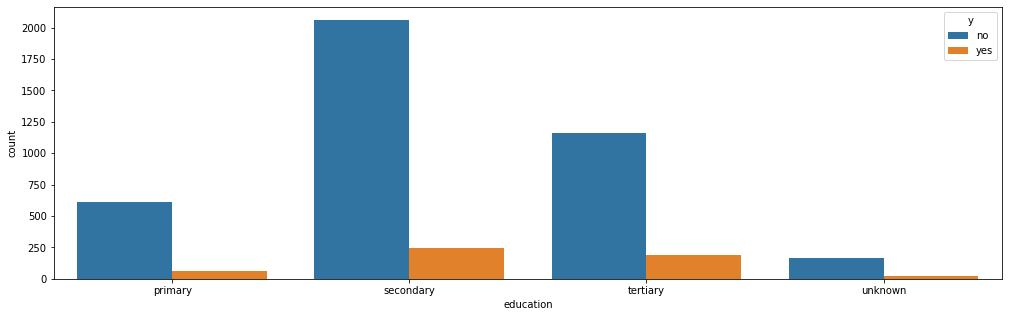

In [ ]:
categoryViseChurn("education", df_bank, "y")

In [ ]:
conversionByCat(df_bank, "education")

,Job,Total,Yes,No,Conversion
1,tertiary,1350,193,1157,14.296
0,secondary,2306,245,2061,10.624
3,unknown,187,19,168,10.160
2,primary,678,64,614,9.440


####Subscription if candidate has a housing loan

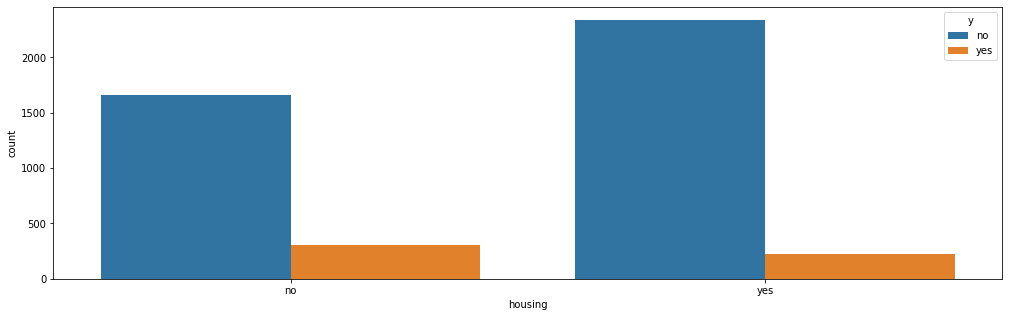

In [ ]:
categoryViseChurn("housing", df_bank, "y")

In [ ]:
conversionByCat(df_bank, "housing")

,Job,Total,Yes,No,Conversion
1,no,1962,301,1661,15.341
0,yes,2559,220,2339,8.597


####Subscription if candidate has a personal loan

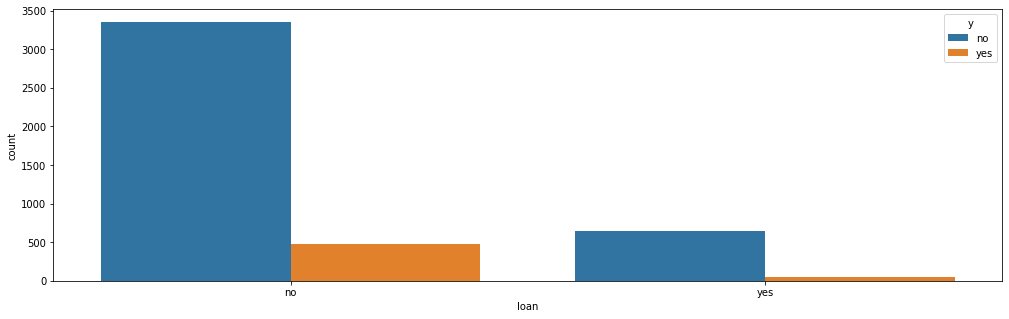

In [ ]:
categoryViseChurn("loan", df_bank, "y")

In [ ]:
conversionByCat(df_bank, "loan")

,Job,Total,Yes,No,Conversion
0,no,3830,478,3352,12.480
1,yes,691,43,648,6.223


####Subscription by mode of contact

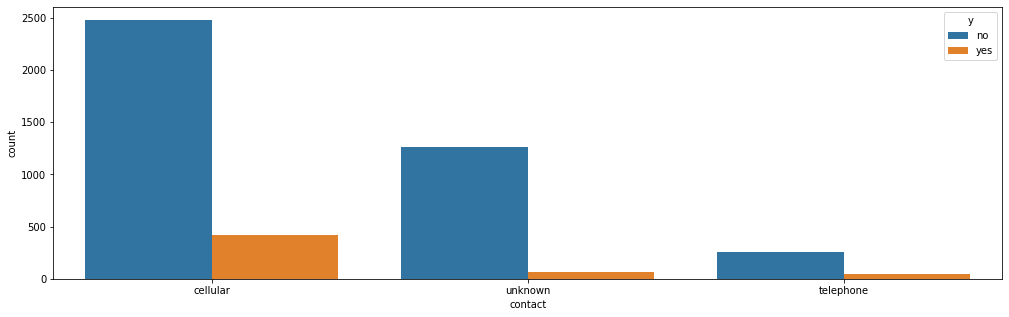

In [ ]:
categoryViseChurn("contact", df_bank, "y")

In [ ]:
conversionByCat(df_bank, "contact")

,Job,Total,Yes,No,Conversion
2,telephone,301,44,257,14.618
0,cellular,2896,416,2480,14.365
1,unknown,1324,61,1263,4.607


####Subscription by month last contacted

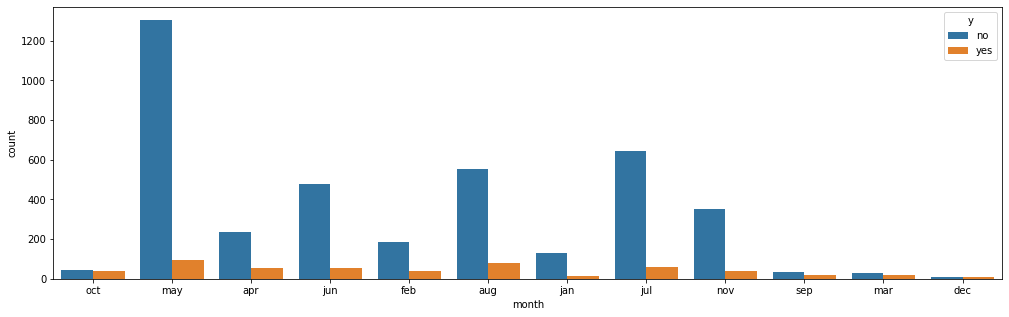

In [ ]:
categoryViseChurn("month", df_bank, "y")

In [ ]:
conversionByCat(df_bank, "month")

,Job,Total,Yes,No,Conversion
8,oct,80,37,43,46.250
11,dec,20,9,11,45.000
10,mar,49,21,28,42.857
9,sep,52,17,35,32.692
5,apr,293,56,237,19.113
6,feb,222,38,184,17.117
2,aug,633,79,554,12.480
7,jan,148,16,132,10.811
3,jun,531,55,476,10.358
4,nov,389,39,350,10.026


####Subscription by outcome of previous marketing campaign

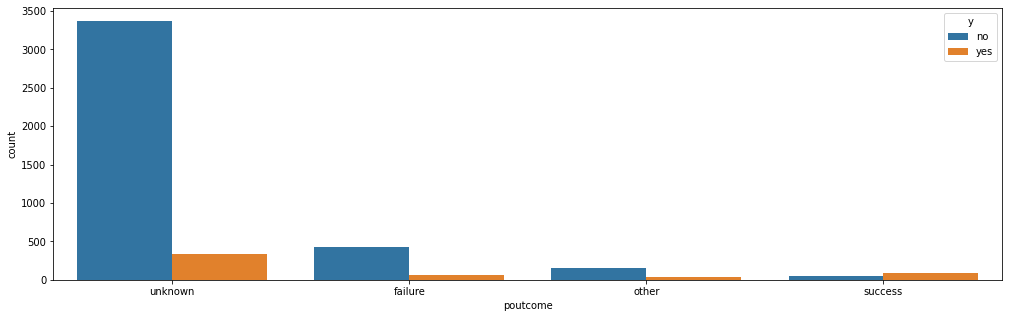

In [ ]:
categoryViseChurn("poutcome", df_bank, "y")

In [ ]:
conversionByCat(df_bank, "poutcome")

,Job,Total,Yes,No,Conversion
3,success,129,83,46,64.341
2,other,197,38,159,19.289
1,failure,490,63,427,12.857
0,unknown,3705,337,3368,9.096


#### ☝ Insights till now

*   Retired candidates and students are more than 2 times more likely to subscribe than blue collar and entreprenuers.
*   Candidate who subscribed previous campaing are 64% more likely to buy the new subscription.


❌ No insights or pattern

*   Unkwown categories doesn't imply any sort of pattern and is not needed as it is Unknown by nature.
*   Mode of contact, months doesn't have any implication.
*   Too many unknown value in poutcome.


###Numeric Variable Vise Churn

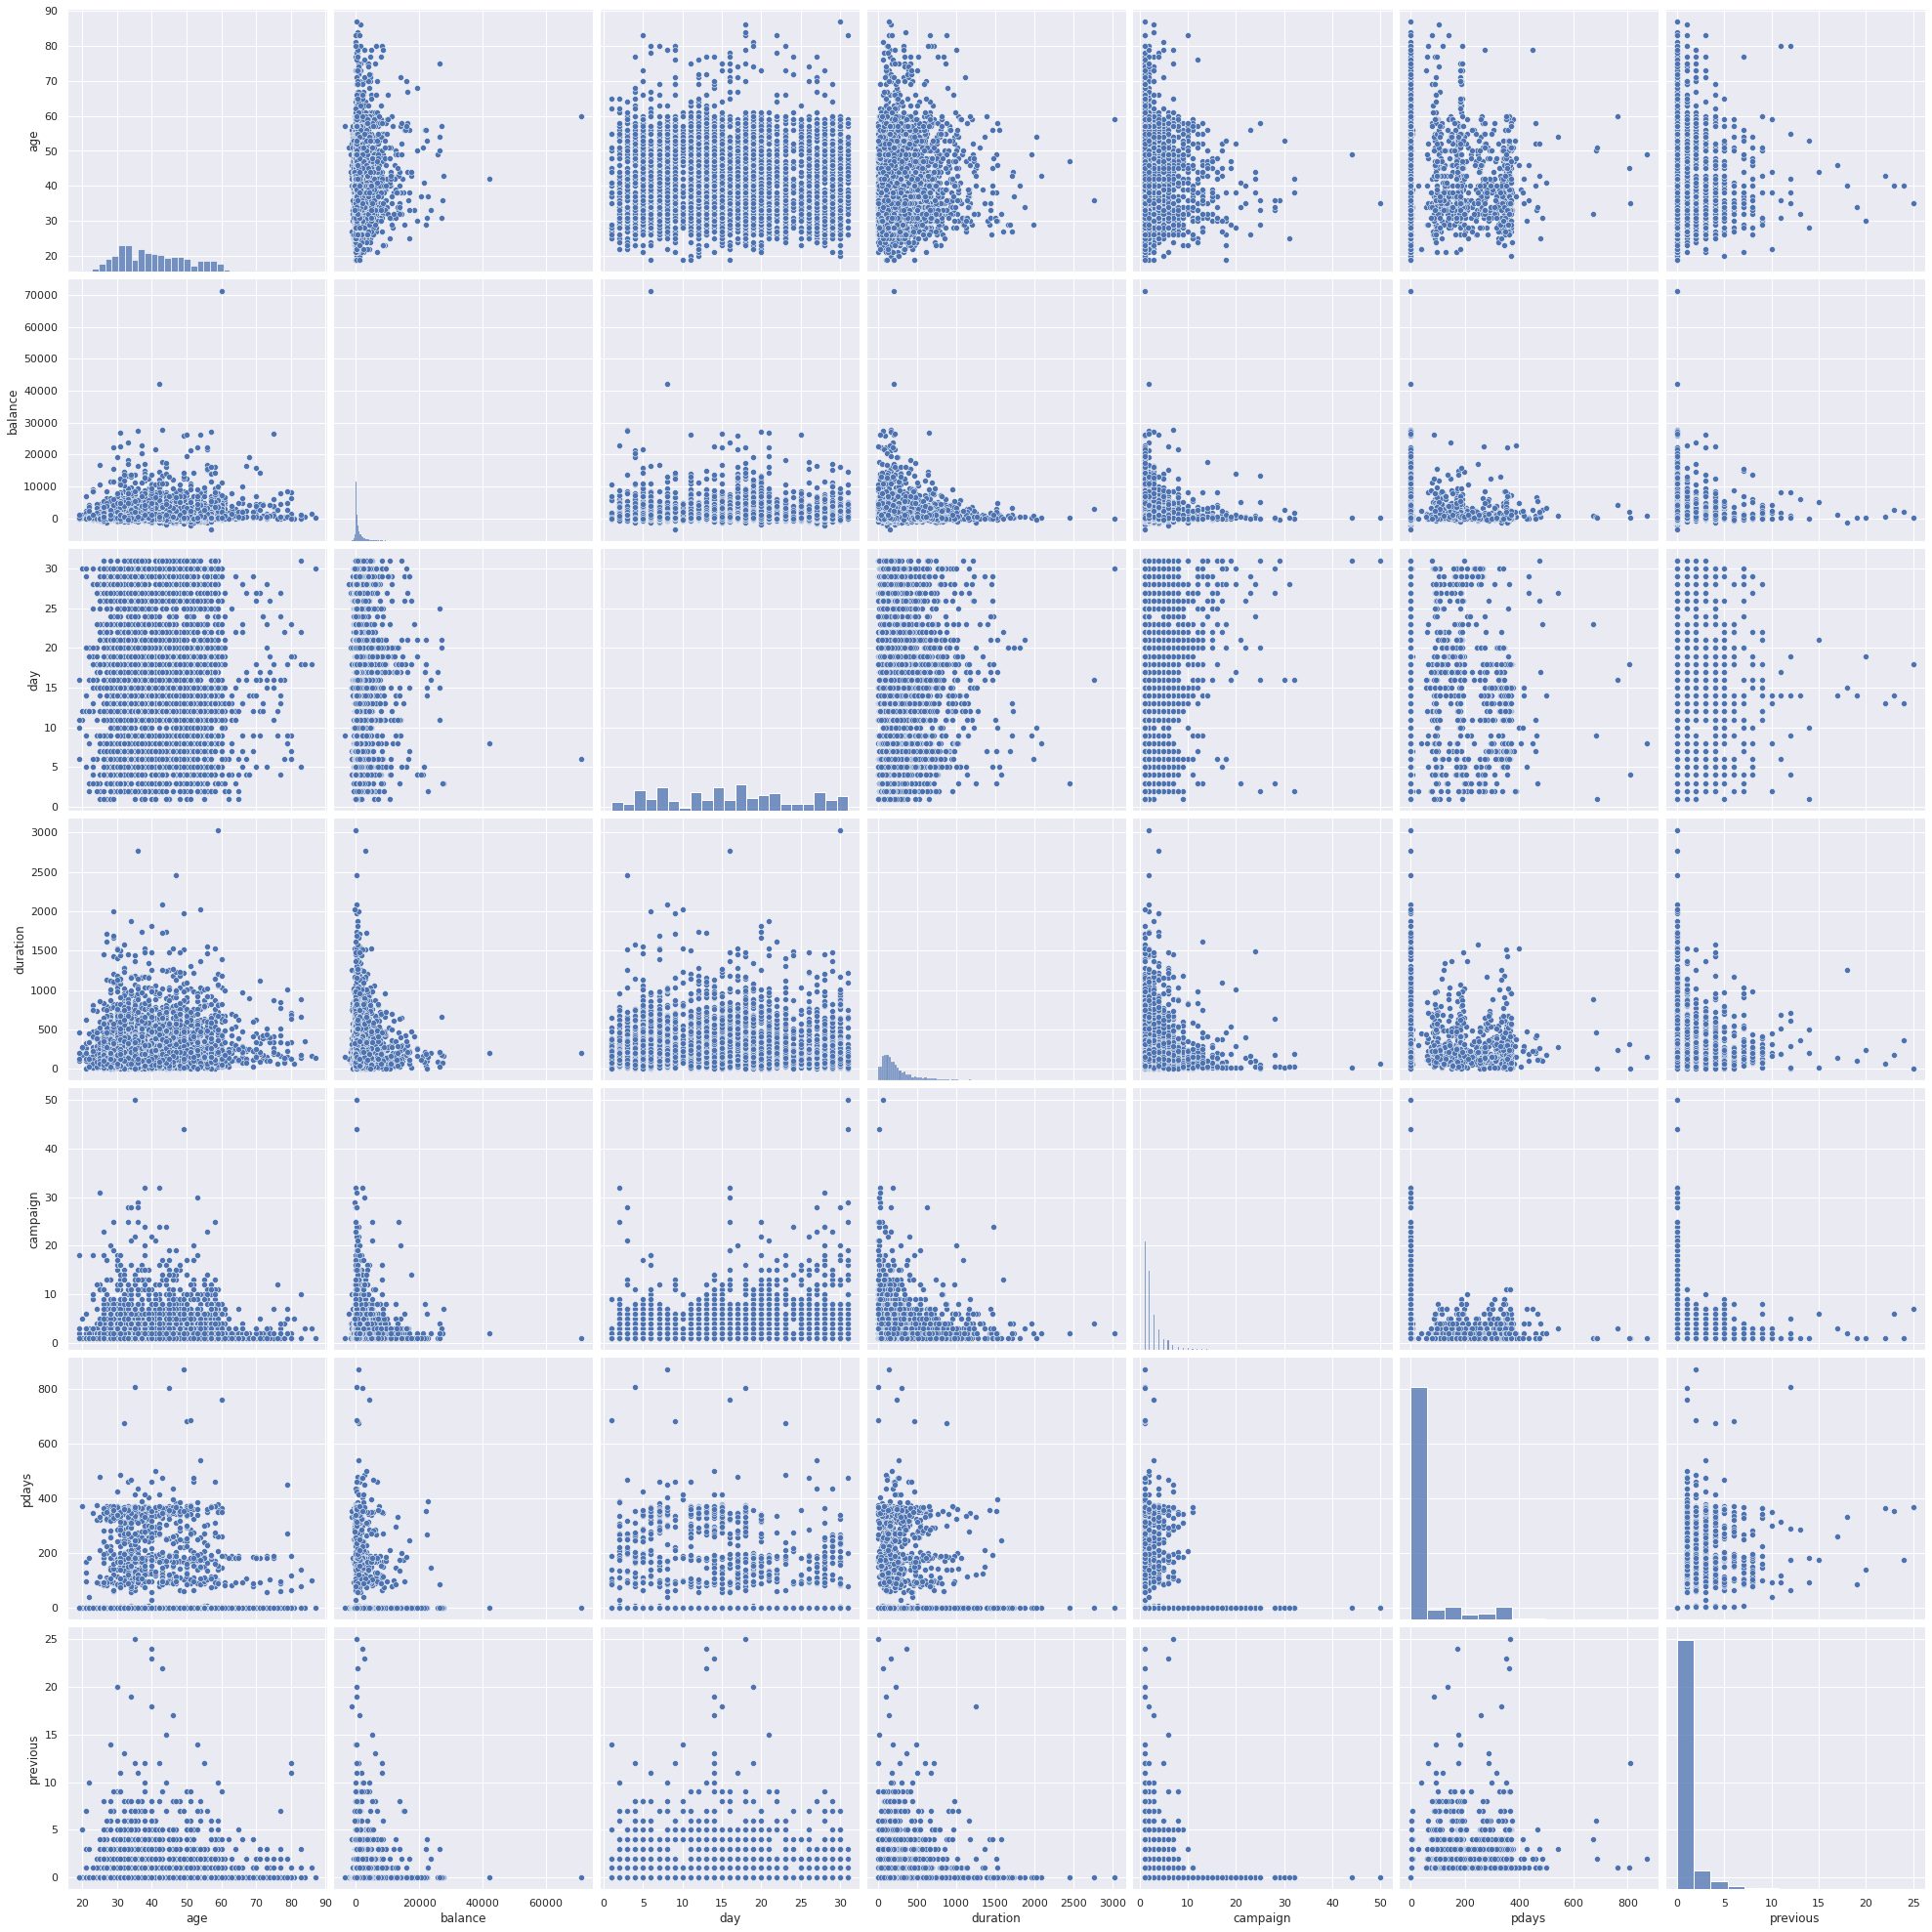

In [ ]:
sns.set()
columns = ['age','balance','day', 'duration','campaign', 'pdays', 'previous']
sns.pairplot(df_bank[columns], size = 4)
plt.show();

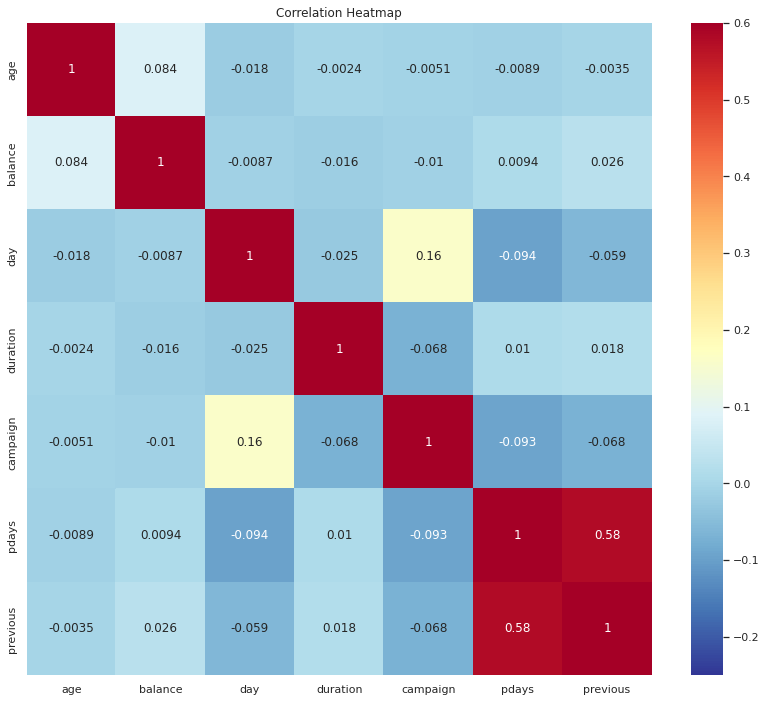

In [ ]:
correlations = df_bank.corr()
plt.figure(figsize = (14, 12))
sns.heatmap(correlations,cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

####❌ No insights or pattern

*   There doesn't appear to be sought of linearity of day and month with other variable also it is same information as pdays.

##Feature Engineering and Selection

In [ ]:
#Working on duplicate copy of data

df_new = df_bank.copy()

In [ ]:
#Dropping column as per our analysis

df_new.drop(['day', 'month', 'contact'], axis = 1, inplace = True)

###Replacing unnecessary unknown values to NAN

In [ ]:
#Let replace the unknown values with null

for i in df_new.columns:
  df_new[i] = np.where(df_new[i] == 'unknown', np.nan, df_new[i])

In [ ]:
df_new.head()

,age,job,marital,education,default,balance,housing,loan,duration,campaign,pdays,previous,poutcome,y
0,30.000,unemployed,married,primary,no,1787.000,no,no,79.000,1.000,-1.000,0.000,NaN,no
1,33.000,services,married,secondary,no,4789.000,yes,yes,220.000,1.000,339.000,4.000,failure,no
2,35.000,management,single,tertiary,no,1350.000,yes,no,185.000,1.000,330.000,1.000,failure,no
3,30.000,management,married,tertiary,no,1476.000,yes,yes,199.000,4.000,-1.000,0.000,NaN,no
4,59.000,blue-collar,married,secondary,no,0.000,yes,no,226.000,1.000,-1.000,0.000,NaN,no


###Checking Missing data again

In [ ]:
checkMissingData(df_new)

,Total,Percent %
poutcome,3705.000,81.951
education,187.000,4.136
job,38.000,0.841
age,0.000,0.000
marital,0.000,0.000
default,0.000,0.000
balance,0.000,0.000
housing,0.000,0.000
loan,0.000,0.000
duration,0.000,0.000


###Removing missing value

👾 Dropping the missing values and since poutcome has more than 50% of missing data. That column is not relevant hence it will be dropped.

In [ ]:
#Dropping the poutcome column

df_new.drop(['poutcome'], axis = 1, inplace = True)

#Dropping the missing value

print(df_new.shape)

df_new.dropna(axis=0, how='any', inplace = True)

df_new.shape

(4521, 13)


(4311, 13)

In [ ]:
checkMissingData(df_new)

,Total,Percent %
age,0.000,0.000
job,0.000,0.000
marital,0.000,0.000
education,0.000,0.000
default,0.000,0.000
balance,0.000,0.000
housing,0.000,0.000
loan,0.000,0.000
duration,0.000,0.000
campaign,0.000,0.000


###Converting categorical data into numeric

In [ ]:
#Converting values to numeric data

#Ordinal Data
df_new['education'].replace({'primary': 0, 'secondary': 1, 'tertiary': 2}, inplace = True)
df_new['marital'].replace({'single': 0, 'married': 1, 'divorced': 2}, inplace = True)
df_new['housing'].replace({'no': 0, 'yes': 1}, inplace = True)
df_new['default'].replace({'no': 0, 'yes': 1}, inplace = True)
df_new['loan'].replace({'no': 0, 'yes': 1}, inplace = True)

In [ ]:
#Nominal Data
one_hot = OneHotEncoder()
df_new[list(df_new['job'].unique())] = one_hot.fit_transform(df_new[['job']]).A
df_new.drop('job', axis = 1, inplace = True)
df_new.head()

,age,marital,education,default,balance,housing,loan,duration,campaign,pdays,...,services,management,blue-collar,self-employed,technician,entrepreneur,admin.,student,housemaid,retired
0,30.000,1,0,0,1787.000,0,0,79.000,1.000,-1.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
1,33.000,1,1,0,4789.000,1,1,220.000,1.000,339.000,...,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000
2,35.000,0,2,0,1350.000,1,0,185.000,1.000,330.000,...,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000
3,30.000,1,2,0,1476.000,1,1,199.000,4.000,-1.000,...,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000
4,59.000,1,1,0,0.000,1,0,226.000,1.000,-1.000,...,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [ ]:
#Output Variable
label = LabelEncoder()
df_new['y'] = label.fit_transform(df_new['y'])
df_new.head()

,age,marital,education,default,balance,housing,loan,duration,campaign,pdays,...,services,management,blue-collar,self-employed,technician,entrepreneur,admin.,student,housemaid,retired
0,30.000,1,0,0,1787.000,0,0,79.000,1.000,-1.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
1,33.000,1,1,0,4789.000,1,1,220.000,1.000,339.000,...,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000
2,35.000,0,2,0,1350.000,1,0,185.000,1.000,330.000,...,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000
3,30.000,1,2,0,1476.000,1,1,199.000,4.000,-1.000,...,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000
4,59.000,1,1,0,0.000,1,0,226.000,1.000,-1.000,...,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


###Checking for Multicolliearity

####Variance Inflation Factor

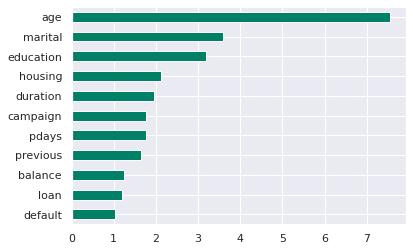

In [ ]:
test = df_new[['age', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'duration', 'campaign', 'pdays', 'previous']]
VIF_list = []

for i in range(test.shape[1]):
  VIF = variance_inflation_factor(test.to_numpy(), i)
  VIF_list.append(VIF)

VIF_plot = pd.Series(VIF_list, index = test.columns)
VIF_plot.sort_values().plot(kind = 'barh', cmap = 'summer')

▶ Except Age there is no variable with high VIF

We will perform some more test to check whether to remove any variable or not

In [ ]:
# Let's Check variance threshold
thres = VarianceThreshold(threshold = 0.0)
thres.fit_transform(test)
thresList = pd.Series(thres.get_support(),index = test.columns)
thresList

age          True
marital      True
education    True
default      True
balance      True
housing      True
loan         True
duration     True
campaign     True
pdays        True
previous     True
dtype: bool

▶ Variance Threshold shows all variables are good predictors

###Making Model

####Splitting input and output variables

In [ ]:
X = df_new.drop('y', axis = 1)
y = df_new['y']

####🏹 Plan of attack 

1.   Creating model for unbalanced dataset
2.   Testing the accuracy
3.   Balancing the dataset using SMOTE
4.   Testing the accuracy

####Splitting the unbalanced dataset for training and test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

####Scaling the data

In [ ]:
#Using Standard Scaler
scaler = StandardScaler()
df_train = scaler.fit_transform(X_train)
df_train

array([[-1.89206597e-01, -1.41025817e+00, -2.40410821e-01, ...,
        -1.23742199e-01, -4.60843720e-01, -1.65570491e-01],
       [ 3.80652326e-03,  2.41991294e-01, -1.75306869e+00, ...,
        -1.23742199e-01, -4.60843720e-01, -1.65570491e-01],
       [-1.15427220e+00, -1.41025817e+00, -2.40410821e-01, ...,
        -1.23742199e-01,  2.16993301e+00, -1.65570491e-01],
       ...,
       [-1.34728532e+00, -1.41025817e+00,  1.27224704e+00, ...,
         8.08131749e+00, -4.60843720e-01, -1.65570491e-01],
       [ 1.96819644e-01,  1.89424076e+00, -1.75306869e+00, ...,
        -1.23742199e-01, -4.60843720e-01, -1.65570491e-01],
       [-9.27000370e-02,  2.41991294e-01, -2.40410821e-01, ...,
        -1.23742199e-01, -4.60843720e-01, -1.65570491e-01]])

In [ ]:
#Converting it into Dataframe
df_train = pd.DataFrame(df_train, columns = X_train.columns)
df_train.head()

,age,marital,education,default,balance,housing,loan,duration,campaign,pdays,...,services,management,blue-collar,self-employed,technician,entrepreneur,admin.,student,housemaid,retired
0,-0.189,-1.410,-0.240,-0.135,-0.306,-1.165,-0.429,-0.979,-0.567,-0.411,...,-0.520,-0.193,-0.158,-0.534,-0.220,-0.206,3.121,-0.124,-0.461,-0.166
1,0.004,0.242,-1.753,-0.135,-0.393,-1.165,-0.429,-0.582,1.331,-0.411,...,-0.520,-0.193,-0.158,-0.534,-0.220,4.843,-0.320,-0.124,-0.461,-0.166
2,-1.154,-1.410,-0.240,-0.135,-0.426,-1.165,-0.429,0.180,-0.567,-0.411,...,-0.520,-0.193,-0.158,-0.534,-0.220,-0.206,-0.320,-0.124,2.170,-0.166
3,0.100,0.242,-1.753,-0.135,-0.463,0.859,-0.429,0.094,0.382,-0.411,...,1.925,-0.193,-0.158,-0.534,-0.220,-0.206,-0.320,-0.124,-0.461,-0.166
4,1.548,0.242,-1.753,-0.135,-0.443,-1.165,-0.429,-0.664,0.066,-0.411,...,-0.520,-0.193,6.328,-0.534,-0.220,-0.206,-0.320,-0.124,-0.461,-0.166


In [ ]:
#Same steps for testing data
df_test = scaler.transform(X_test)
df_test = pd.DataFrame(df_test, columns = X_test.columns)
df_test.head()

,age,marital,education,default,balance,housing,loan,duration,campaign,pdays,...,services,management,blue-collar,self-employed,technician,entrepreneur,admin.,student,housemaid,retired
0,-0.093,1.894,-0.240,-0.135,0.155,-1.165,2.331,0.011,-0.567,-0.411,...,-0.520,-0.193,-0.158,-0.534,-0.220,4.843,-0.320,-0.124,-0.461,-0.166
1,0.197,0.242,-1.753,-0.135,-0.145,0.859,2.331,-0.094,-0.251,-0.411,...,-0.520,-0.193,-0.158,-0.534,-0.220,-0.206,-0.320,-0.124,-0.461,6.040
2,0.390,0.242,-1.753,-0.135,-0.441,0.859,-0.429,-0.551,0.066,3.265,...,-0.520,5.177,-0.158,-0.534,-0.220,-0.206,-0.320,-0.124,-0.461,-0.166
3,1.741,0.242,1.272,-0.135,2.711,-1.165,-0.429,-0.120,-0.251,-0.411,...,-0.520,-0.193,-0.158,-0.534,4.548,-0.206,-0.320,-0.124,-0.461,-0.166
4,-1.058,-1.410,-0.240,-0.135,-0.318,0.859,-0.429,0.278,0.066,-0.411,...,-0.520,-0.193,-0.158,-0.534,-0.220,-0.206,3.121,-0.124,-0.461,-0.166


####Training the model with different algorithms

In [ ]:
model_list = [('Random Forest', RandomForestClassifier()),
             ('Ada Boost', AdaBoostClassifier()),
             ('Logistic Regression', LogisticRegression()),
             ('KNN Classifier', KNeighborsClassifier()),
             ('XG Boost', XGBClassifier())]

for name, model in model_list:
  model.fit(df_train, y_train)
  y1_predict = model.predict(df_train)
  accuracy = accuracy_score(y_train, y1_predict)
  y2_predict = model.predict(df_test)
  accuracy_test = accuracy_score(y_test, y2_predict)
  print(f'For {name} : The training acccuracy is : {accuracy} | \t Testing Accuracy is : {accuracy_test}')
  print('_'*30)

For Random Forest : The training acccuracy is : 1.0 | 	 Testing Accuracy is : 0.8864426419466975
______________________________
For Ada Boost : The training acccuracy is : 0.8970417633410673 | 	 Testing Accuracy is : 0.8852838933951332
______________________________
For Logistic Regression : The training acccuracy is : 0.8915313225058005 | 	 Testing Accuracy is : 0.8852838933951332
______________________________
For KNN Classifier : The training acccuracy is : 0.9127030162412993 | 	 Testing Accuracy is : 0.8794901506373117
______________________________
For XG Boost : The training acccuracy is : 0.9190835266821346 | 	 Testing Accuracy is : 0.8922363847045192
______________________________


####⚡ Outcome

Random forest gave the best training accuracy but 11.8 percent less testing accuracy which means the model is overfit

XG Boost has the best training as well as  testing score without overfitting. So we will continue with XGB model

####Traning the XGB model again

In [ ]:
xgb = XGBClassifier()
xgb.fit(df_train, y_train)

XGBClassifier()

####Evaluting the model on train

In [ ]:
y1_predict = xgb.predict(df_train)
accuracy = accuracy_score(y_train, y1_predict)
print(f'The training acccuracy is : {accuracy}')

The training acccuracy is : 0.9190835266821346


In [ ]:
report = classification_report(y_train,y1_predict)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.98      0.96      3050
           1       0.78      0.42      0.54       398

    accuracy                           0.92      3448
   macro avg       0.85      0.70      0.75      3448
weighted avg       0.91      0.92      0.91      3448



In [ ]:
mat = confusion_matrix(y_train, y1_predict)
print(mat)

[[3003   47]
 [ 232  166]]


####Evaluating the model on Testing

In [ ]:
y2_predict = model.predict(df_test)
accuracy_test = accuracy_score(y_test, y2_predict)
print(f'The testing acccuracy is : {accuracy_test}')

The testing acccuracy is : 0.8922363847045192


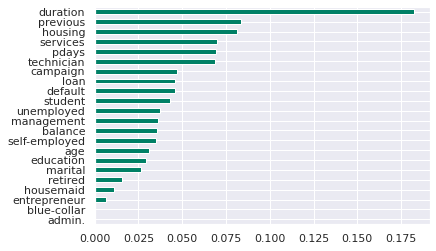

In [ ]:
#Checking how much each variable is important
coef = pd.Series(xgb.feature_importances_, df_test.columns)
coef.sort_values().plot(kind = 'barh', cmap = 'summer')


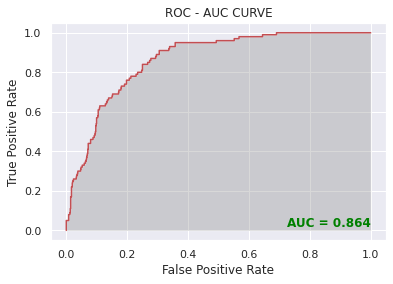

In [ ]:
# Ploting the Roc - Auc Curve on Testing data
y_prob = xgb.predict_proba(df_test)
y_prob   = y_prob[:,1]
auc_score = roc_auc_score(y_test, y_prob)
fp,tp,threshold = roc_curve(y_test,y_prob)
plt.plot(fp,tp, "r")
plt.text(1, 0.02, 'AUC = %0.3f' % auc_score, ha='right', fontsize=12,weight='bold', color='green')
plt.fill_between(fp, tp, facecolor='grey', alpha=0.3)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC - AUC CURVE")
plt.show()

####Fine Tuning the model

In [ ]:
estimators = XGBClassifier()
parameters = {'n_estimators': [50, 100, 1150, 200, 250, 300, 350, 400],
              'max_depth': np.arange(2,10),
              'learning_rate': np.arange(0.01, 0.1, 0.02),
              'subsample': np.arange(0.5, 1.0, 0.1),
              'colsample_bytree': np.arange(0.4, 1.0, 0.1),
              'colsample_bylevel': np.arange(0.4, 1.0, 0.1)}

rsCV = RandomizedSearchCV(estimators, parameters, cv=5, random_state=42)
rsCV.fit(df_train, y_train)
rsCV.best_params_

{'subsample': 0.6,
 'n_estimators': 100,
 'max_depth': 6,
 'learning_rate': 0.03,
 'colsample_bytree': 0.7999999999999999,
 'colsample_bylevel': 0.8999999999999999}

In [ ]:
xgb = XGBClassifier(subsample = 0.6, n_estimators = 100,
                    max_depth = 6, learning_rate = 0.03,
                    colsample_bytree = 0.7, colsample_bylevel = 0.8)

In [ ]:
xgb.fit(df_train, y_train)

XGBClassifier(colsample_bylevel=0.8, colsample_bytree=0.7, learning_rate=0.03,
              max_depth=6, subsample=0.6)

####Performing evalution on fined tuned model

#####On Training

In [ ]:
y1_predict = model.predict(df_train)
accuracy = accuracy_score(y_train, y1_predict)
print(f'The training acccuracy is : {accuracy}')

The training acccuracy is : 0.9190835266821346


#####On Testing

In [ ]:
y2_predict = model.predict(df_test)
accuracy_test = accuracy_score(y_test, y2_predict)
print(f'The testing acccuracy is : {accuracy_test}')

The testing acccuracy is : 0.8922363847045192


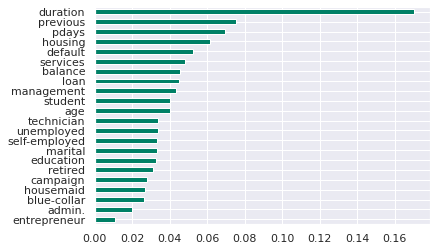

In [ ]:
coef = pd.Series(xgb.feature_importances_, df_test.columns)
coef.sort_values().plot(kind = 'barh', cmap = 'summer')

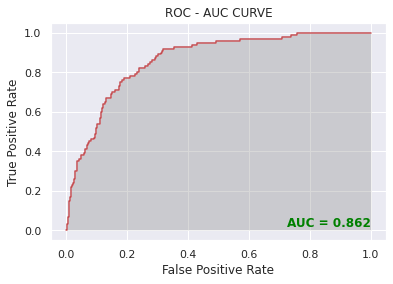

In [ ]:
# Ploting the Roc - Auc Curve on Testing data
y_prob = xgb.predict_proba(df_test)
y_prob   = y_prob[:,1]
auc_score = roc_auc_score(y_test, y_prob)
fp,tp,threshold = roc_curve(y_test,y_prob)
plt.plot(fp,tp, "r")
plt.text(1, 0.02, 'AUC = %0.3f' % auc_score, ha='right', fontsize=12,weight='bold', color='green')
plt.fill_between(fp, tp, facecolor='grey', alpha=0.3)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC - AUC CURVE")
plt.show()

####Using SMOTE to balance the data

In [ ]:
smote = SMOTE(sampling_strategy=0.75)
dfs_X,dfs_y = smote.fit_resample(X,y)

In [ ]:
dfs_y.value_counts()

0    3813
1    2859
Name: y, dtype: int64

#####Splitting the data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dfs_X, dfs_y, test_size=0.2, random_state=42, stratify=dfs_y)

#####Scaling the data

In [ ]:
#Using Standard Scaler
scaler = StandardScaler()
dfs_train = scaler.fit_transform(X_train)
dfs_train

array([[-0.59859439,  0.41688037, -0.14056715, ..., -0.16957328,
         2.29325335, -0.17422271],
       [-0.9921788 , -1.23240838, -0.14056715, ...,  6.69349776,
        -0.49667629, -0.17422271],
       [ 0.8254771 ,  0.41688037, -1.70349816, ..., -0.16957328,
        -0.49667629, -0.17422271],
       ...,
       [-0.50365629, -1.23240838,  1.42236386, ..., -0.16957328,
        -0.49667629, -0.17422271],
       [-0.78847059,  0.41688037, -1.70349816, ..., -0.16957328,
        -0.49667629, -0.17422271],
       [ 0.730539  ,  0.41688037,  1.42236386, ..., -0.16957328,
         2.29325335, -0.17422271]])

In [ ]:
#Converting it into Dataframe
dfs_train = pd.DataFrame(dfs_train, columns = X_train.columns)
dfs_train.head()

,age,marital,education,default,balance,housing,loan,duration,campaign,pdays,...,services,management,blue-collar,self-employed,technician,entrepreneur,admin.,student,housemaid,retired
0,-0.599,0.417,-0.141,-0.106,-0.521,1.131,-0.336,0.460,-0.594,0.484,...,-0.496,-0.185,-0.184,-0.590,-0.288,-0.213,-0.326,-0.170,2.293,-0.174
1,-0.992,-1.232,-0.141,-0.106,0.035,-0.884,-0.336,0.823,0.425,-0.478,...,-0.496,-0.185,-0.184,-0.590,0.073,-0.213,-0.326,6.693,-0.497,-0.174
2,0.825,0.417,-1.703,-0.106,0.947,1.131,-0.336,0.466,-0.224,-0.478,...,2.218,-0.185,-0.184,-0.590,-0.288,-0.213,-0.326,-0.170,-0.497,-0.174
3,-0.219,0.417,1.422,-0.106,-0.202,1.131,-0.336,0.363,-0.594,2.764,...,-0.496,-0.185,-0.184,1.926,-0.288,-0.213,-0.326,-0.170,-0.497,-0.174
4,-0.609,0.417,-0.141,-0.106,0.544,-0.884,-0.336,0.193,0.393,0.977,...,-0.496,5.200,-0.184,-0.312,-0.288,-0.213,-0.326,-0.170,-0.497,-0.174


In [ ]:
#Same steps for testing data
dfs_test = scaler.transform(X_test)
dfs_test = pd.DataFrame(dfs_test, columns = X_test.columns)
dfs_test.head()

,age,marital,education,default,balance,housing,loan,duration,campaign,pdays,...,services,management,blue-collar,self-employed,technician,entrepreneur,admin.,student,housemaid,retired
0,-1.168,0.417,-0.141,-0.106,-0.501,1.131,-0.336,-0.078,2.365,-0.478,...,-0.496,-0.185,-0.184,-0.590,-0.288,-0.213,3.460,-0.170,-0.497,-0.174
1,0.703,0.417,-1.703,-0.106,-0.681,1.131,-0.336,0.555,-0.594,-0.478,...,2.121,-0.185,-0.184,-0.590,-0.288,-0.213,-0.326,-0.170,-0.497,-0.174
2,-1.453,-1.232,1.422,-0.106,-0.066,1.131,-0.336,-0.527,-0.594,0.365,...,-0.496,-0.185,-0.184,1.926,-0.288,-0.213,-0.326,-0.170,-0.497,-0.174
3,0.311,-1.232,-0.141,-0.106,-0.437,-0.884,-0.336,4.003,0.462,-0.478,...,-0.496,-0.185,-0.184,-0.590,-0.288,-0.213,-0.326,-0.170,2.158,-0.174
4,1.664,0.417,-1.703,-0.106,-0.521,-0.884,-0.336,0.370,-0.224,-0.478,...,-0.496,-0.127,-0.184,-0.590,4.104,-0.213,-0.326,-0.170,-0.497,-0.174


#####Training on different models

In [ ]:
for name, model in model_list:
  model.fit(dfs_train, y_train)
  y1_predict = model.predict(dfs_train)
  accuracy = accuracy_score(y_train, y1_predict)
  y2_predict = model.predict(dfs_test)
  accuracy_test = accuracy_score(y_test, y2_predict)
  print(f'For {name} : The training acccuracy is : {accuracy} | \t Testing Accuracy is : {accuracy_test}')
  print('_'*30)

For Random Forest : The training acccuracy is : 1.0 | 	 Testing Accuracy is : 0.9220973782771535
______________________________
For Ada Boost : The training acccuracy is : 0.9083754918493536 | 	 Testing Accuracy is : 0.8936329588014982
______________________________
For Logistic Regression : The training acccuracy is : 0.8332396477421773 | 	 Testing Accuracy is : 0.8239700374531835
______________________________
For KNN Classifier : The training acccuracy is : 0.9162450815064643 | 	 Testing Accuracy is : 0.8794007490636704
______________________________
For XG Boost : The training acccuracy is : 0.9301105489975642 | 	 Testing Accuracy is : 0.9078651685393259
______________________________


We will again take XGB as the model as random forest is slightly overfitting

#####Fine Tuning the model

In [ ]:
estimators = XGBClassifier()
parameters = {'n_estimators': [50, 100, 1150, 200, 250, 300, 350, 400],
              'max_depth': np.arange(2,10),
              'learning_rate': np.arange(0.01, 0.1, 0.02),
              'subsample': np.arange(0.5, 1.0, 0.1),
              'colsample_bytree': np.arange(0.4, 1.0, 0.1),
              'colsample_bylevel': np.arange(0.4, 1.0, 0.1)}

rsCV = RandomizedSearchCV(estimators, parameters, cv=5, random_state=42)
rsCV.fit(dfs_train, y_train)
rsCV.best_params_

{'subsample': 0.7999999999999999,
 'n_estimators': 250,
 'max_depth': 8,
 'learning_rate': 0.08999999999999998,
 'colsample_bytree': 0.7,
 'colsample_bylevel': 0.8999999999999999}

In [ ]:
xgb = XGBClassifier(subsample = 0.7, n_estimators = 250,
                    max_depth = 8, learning_rate = 0.08,
                    colsample_bytree = 0.7, colsample_bylevel = 0.8)

In [ ]:
xgb.fit(dfs_train, y_train)

XGBClassifier(colsample_bylevel=0.8, colsample_bytree=0.7, learning_rate=0.08,
              max_depth=8, n_estimators=250, subsample=0.7)

#####Evaluating the model

In [ ]:
y1_predict = model.predict(dfs_train)
accuracy = accuracy_score(y_train, y1_predict)
print(f'The training acccuracy is : {accuracy}')

The training acccuracy is : 0.9301105489975642


In [ ]:
y2_predict = model.predict(dfs_test)
accuracy_test = accuracy_score(y_test, y2_predict)
print(f'The testing acccuracy is : {accuracy_test}')

The testing acccuracy is : 0.9078651685393259


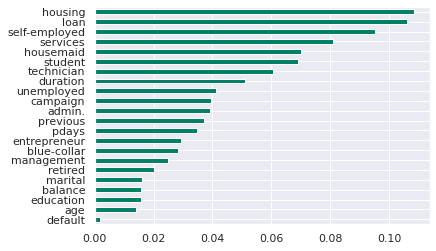

In [ ]:
coef = pd.Series(xgb.feature_importances_, dfs_test.columns)
coef.sort_values().plot(kind = 'barh', cmap = 'summer')

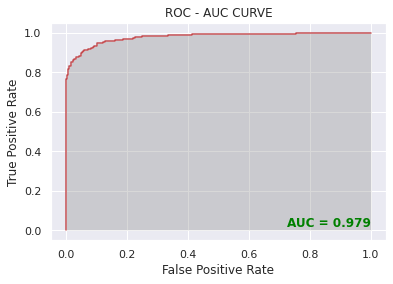

In [ ]:
# Ploting the Roc - Auc Curve on Testing data
y_prob = xgb.predict_proba(dfs_test)
y_prob   = y_prob[:,1]
auc_score = roc_auc_score(y_test, y_prob)
fp,tp,threshold = roc_curve(y_test,y_prob)
plt.plot(fp,tp, "r")
plt.text(1, 0.02, 'AUC = %0.3f' % auc_score, ha='right', fontsize=12,weight='bold', color='green')
plt.fill_between(fp, tp, facecolor='grey', alpha=0.3)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC - AUC CURVE")
plt.show()